In [2]:
!pip install disarray

In [3]:
import tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import disarray

In [4]:
def count_jpg_files(root_dir):
    """
    Count all .jpg files in the given directory and its subdirectories
    
    Args:
        root_dir (str): Path to the root directory to start searching from
        
    Returns:
        int: total count
    """
    total_count = 0
    dir_counts = {}
    
    # Walk through all directories
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Count jpg files in current directory
        jpg_count = len([f for f in filenames if f.lower().endswith('.jpg')])
        total_count += jpg_count
    
    return total_count

In [5]:
train_path = '/kaggle/input/multiclassoriginalimages/train_directory'
validation_path = '/kaggle/input/multiclassoriginalimages/validation_directory'
test_path = '/kaggle/input/multiclassoriginalimages/test_directory'

In [6]:
preprocess_input = tensorflow.keras.applications.resnet50.preprocess_input

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
batch_size = 64
train_image_gen = image_gen.flow_from_directory(train_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical')

val_image_gen = image_gen.flow_from_directory(validation_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

test_image_gen = image_gen.flow_from_directory(test_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

print(test_image_gen.class_indices)

Found 36927 images belonging to 7 classes.
Found 883 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [8]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [9]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1_score_value = 2*((precision_value*recall_value)/(precision_value+recall_value+K.epsilon()))
    return f1_score_value

In [10]:
tl_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 24,060,935 (91.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [11]:
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy, precision, recall, f1_score])

In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(
    monitor='val_categorical_accuracy',
    factor=0.1,
    patience=2,        
    mode='max',
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,       
    mode='min',
    restore_best_weights=True,
    verbose=1
)

model_chkpt = ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    verbose=1
)

callback_list = [model_chkpt, lr_reduce, early_stop]

In [13]:
total_samples = sum([5115, 5950, 5990, 5462, 5510, 4810, 4090])
class_weights = {
    0: total_samples / 5510,
    1: total_samples / 5462,
    2: total_samples / 5990,
    3: total_samples / 4090,
    4: total_samples / 5950,
    5: total_samples / 5115,
    6: total_samples / 4810
}

In [14]:
history = tl_model.fit(train_image_gen,
                       epochs=30, 
                       validation_data = val_image_gen,
                       class_weight = class_weights,
                       callbacks=callback_list)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - categorical_accuracy: 0.6211 - f1_score: 0.5846 - loss: 11.2766 - precision: 0.7234 - recall: 0.5042 - top_2_accuracy: 0.8012 - top_3_accuracy: 0.8925
Epoch 1: val_categorical_accuracy improved from -inf to 0.87089, saving model to best_model.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 346s 488ms/step - categorical_accuracy: 0.6212 - f1_score: 0.5848 - loss: 11.2732 - precision: 0.7235 - recall: 0.5045 - top_2_accuracy: 0.8013 - top_3_accuracy: 0.8926 - val_categorical_accuracy: 0.8709 - val_f1_score: 0.8604 - val_loss: 4.3904 - val_precision: 0.8756 - val_recall: 0.8484 - val_top_2_accuracy: 0.9513 - val_top_3_accuracy: 0.9830 - learning_rate: 1.0000e-04
Epoch 2/30
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - categorical_accuracy: 0.8633 - f1_score: 0.8619 - loss: 6.2423 - precision: 0.8896 - recall: 0.8363 - top_2_accuracy: 0.9671 - top_3_accuracy: 0.9917
Epoch 2: val_categorical_accuracy improved from 0.87089 to 0.89015, saving model to best_model

In [15]:
tl_model.save('val_loss_epoch.keras')

<Axes: >

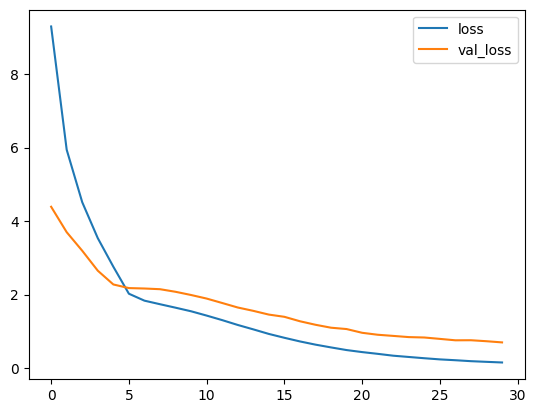

In [17]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

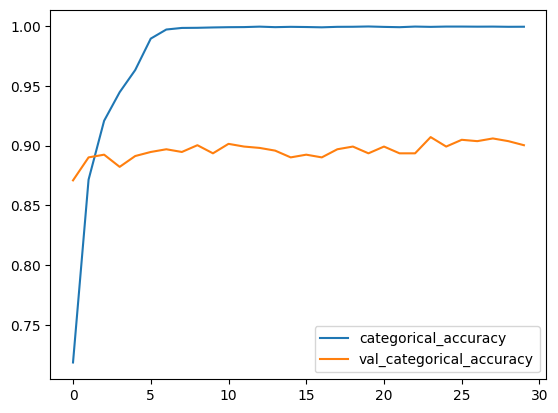

In [18]:
metrics[["categorical_accuracy","val_categorical_accuracy"]].plot()

<Figure size 640x480 with 0 Axes>

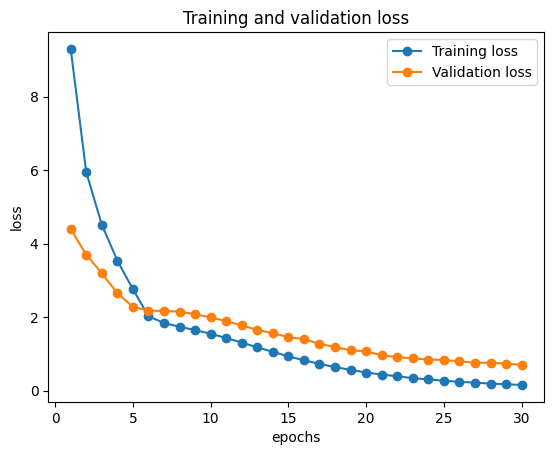

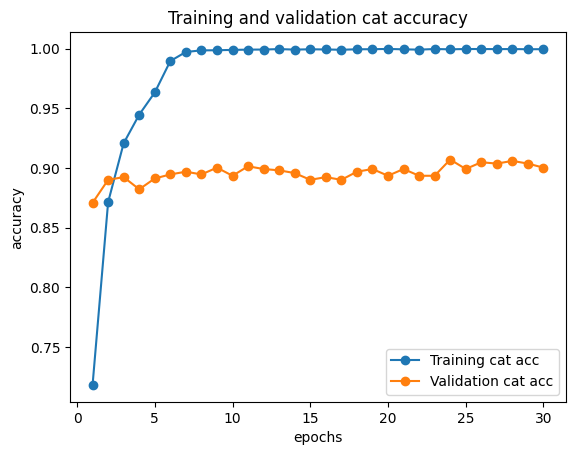

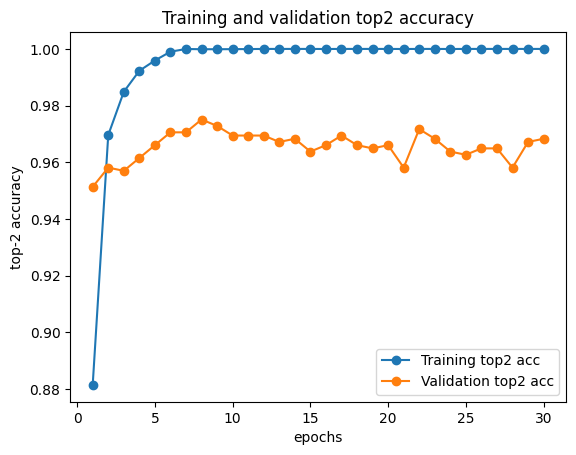

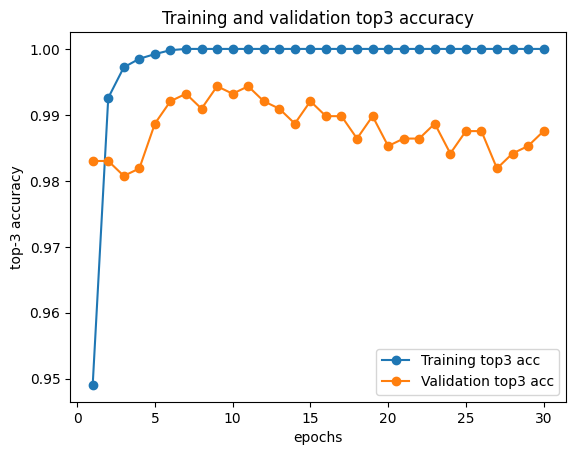

<Figure size 640x480 with 0 Axes>

In [19]:
# display the accuracy, top-2 accuracy and top-3 accuracy

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, "-o", label='Training loss')
plt.plot(epochs, val_loss, "-o", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
# plt.figure()
plt.savefig('loss.png', dpi=300)
plt.figure()

plt.plot(epochs, acc, "-o", label='Training cat acc')
plt.plot(epochs, val_acc, "-o", label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
# plt.figure()
plt.savefig('acc.png', dpi=300)
plt.figure()

plt.plot(epochs, train_top2_acc, "-o", label='Training top2 acc')
plt.plot(epochs, val_top2_acc, "-o", label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-2 accuracy')
plt.legend()
# plt.figure()
plt.savefig('top2acc.png', dpi=300)
plt.figure()

plt.plot(epochs, train_top3_acc, "-o", label='Training top3 acc')
plt.plot(epochs, val_top3_acc, "-o", label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-3 accuracy')
plt.legend()
# plt.figure()
plt.savefig('top3acc.png', dpi=300)
plt.figure()

In [20]:
tl_model.load_weights('best_model.keras')
VALIDATION_STEPS = int(np.ceil(count_jpg_files(validation_path) / 64))

In [21]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc, val_precision, val_recall, val_f1_score = tl_model.evaluate(val_image_gen, steps=VALIDATION_STEPS)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_f1_score', val_f1_score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - categorical_accuracy: 0.8171 - f1_score: 0.8220 - loss: 1.3908 - precision: 0.8282 - recall: 0.8161 - top_2_accuracy: 0.9211 - top_3_accuracy: 0.9606
val_loss: 0.8448622226715088
val_cat_acc: 0.9071347713470459
val_top_2_acc: 0.9637598991394043
val_top_3_acc: 0.9841449856758118
val_precision: 0.9113702178001404
val_recall: 0.9065126180648804
val_f1_score 0.9088850617408752


In [22]:
TEST_STEPS = int(np.ceil(count_jpg_files(test_path) / 64))

In [23]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc, test_precision, test_recall, test_f1_score = tl_model.evaluate(test_image_gen, steps=TEST_STEPS)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)
print('test_precision:', test_precision)
print('test_recall:', test_recall)
print('test_f1_score', test_f1_score)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 566ms/step - categorical_accuracy: 0.8216 - f1_score: 0.8181 - loss: 1.2396 - precision: 0.8223 - recall: 0.8141 - top_2_accuracy: 0.9387 - top_3_accuracy: 0.9604
test_loss: 0.7373353838920593
test_cat_acc: 0.9156845211982727
test_top_2_acc: 0.9728014469146729
test_top_3_acc: 0.9836808443069458
test_precision: 0.920089066028595
test_recall: 0.9166666865348816
test_f1_score 0.91835618019104


In [24]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes
cm = confusion_matrix(test_labels, predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step


Normalized confusion matrix
[[0.53333333 0.1        0.06666667 0.03333333 0.1        0.16666667
  0.        ]
 [0.08571429 0.71428571 0.14285714 0.         0.         0.05714286
  0.        ]
 [0.01136364 0.03409091 0.64772727 0.         0.125      0.18181818
  0.        ]
 [0.         0.125      0.         0.375      0.         0.5
  0.        ]
 [0.02173913 0.02173913 0.08695652 0.         0.56521739 0.30434783
  0.        ]
 [0.         0.00226501 0.00453001 0.0011325  0.00679502 0.98527746
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


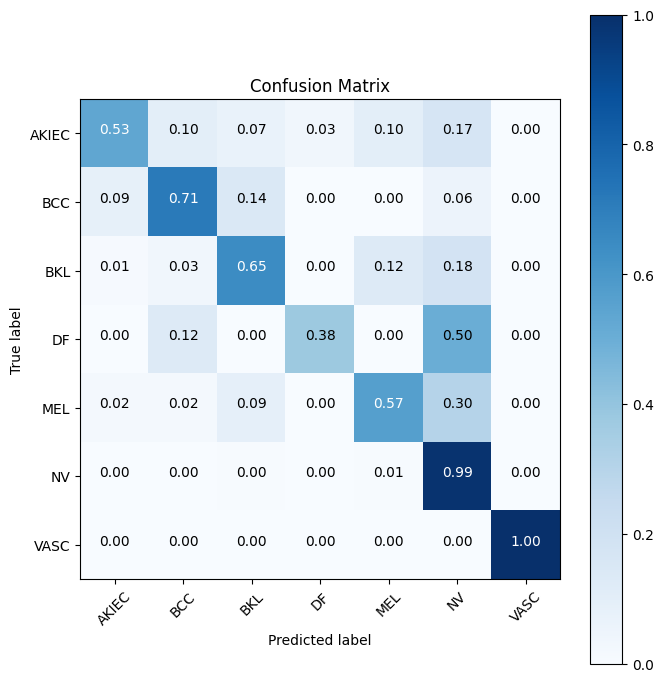

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusionmatrix.png', dpi=300)

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [26]:
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.982774,0.981868,0.958296,0.993654,0.963735,0.951043,1.0,0.975910
f1,0.627451,0.714286,0.712500,0.461538,0.565217,0.969900,1.0,0.915684
false_discovery_rate,0.238095,0.285714,0.208333,0.400000,0.434783,0.045005,0.0,0.084316
false_negative_rate,0.466667,0.285714,0.352273,0.625000,0.434783,0.014723,0.0,0.084316
false_positive_rate,0.004660,0.009363,0.014778,0.001826,0.018921,0.186364,0.0,0.014053
negative_predictive_value,0.987061,0.990637,0.969932,0.995446,0.981079,0.932292,1.0,0.985947
positive_predictive_value,0.761905,0.714286,0.791667,0.600000,0.565217,0.954995,1.0,0.915684
precision,0.761905,0.714286,0.791667,0.600000,0.565217,0.954995,1.0,0.915684
recall,0.533333,0.714286,0.647727,0.375000,0.565217,0.985277,1.0,0.915684
sensitivity,0.533333,0.714286,0.647727,0.375000,0.565217,0.985277,1.0,0.915684


In [37]:
tl_model.load_weights('val_loss_epoch.keras')
VALIDATION_STEPS = int(np.ceil(count_jpg_files(validation_path) / 64))

In [38]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc, val_precision, val_recall, val_f1_score = tl_model.evaluate(val_image_gen, steps=VALIDATION_STEPS)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_f1_score', val_f1_score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - categorical_accuracy: 0.8114 - f1_score: 0.8099 - loss: 1.2359 - precision: 0.8147 - recall: 0.8052 - top_2_accuracy: 0.9295 - top_3_accuracy: 0.9741
val_loss: 0.7005378603935242
val_cat_acc: 0.9003397226333618
val_top_2_acc: 0.9682899117469788
val_top_3_acc: 0.987542450428009
val_precision: 0.9025728106498718
val_recall: 0.8978685140609741
val_f1_score 0.9001907110214233


In [42]:
TEST_STEPS = int(np.ceil(count_jpg_files(test_path) / 64))

In [43]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc, test_precision, test_recall, test_f1_score = tl_model.evaluate(test_image_gen, steps=TEST_STEPS)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)
print('test_precision:', test_precision)
print('test_recall:', test_recall)
print('test_f1_score', test_f1_score)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - categorical_accuracy: 0.8062 - f1_score: 0.8070 - loss: 1.0981 - precision: 0.8112 - recall: 0.8028 - top_2_accuracy: 0.9236 - top_3_accuracy: 0.9665
test_loss: 0.6005071997642517
test_cat_acc: 0.9111514091491699
test_top_2_acc: 0.9673617482185364
test_top_3_acc: 0.985494077205658
test_precision: 0.9171996712684631
test_recall: 0.9131944179534912
test_f1_score 0.9151684641838074


In [44]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes
cm = confusion_matrix(test_labels, predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step


Normalized confusion matrix
[[0.46666667 0.13333333 0.13333333 0.03333333 0.06666667 0.16666667
  0.        ]
 [0.14285714 0.6        0.11428571 0.         0.         0.14285714
  0.        ]
 [0.01136364 0.02272727 0.69318182 0.         0.09090909 0.18181818
  0.        ]
 [0.         0.125      0.         0.375      0.125      0.375
  0.        ]
 [0.02173913 0.02173913 0.08695652 0.         0.54347826 0.30434783
  0.02173913]
 [0.0011325  0.00226501 0.00906002 0.0011325  0.00339751 0.98301246
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


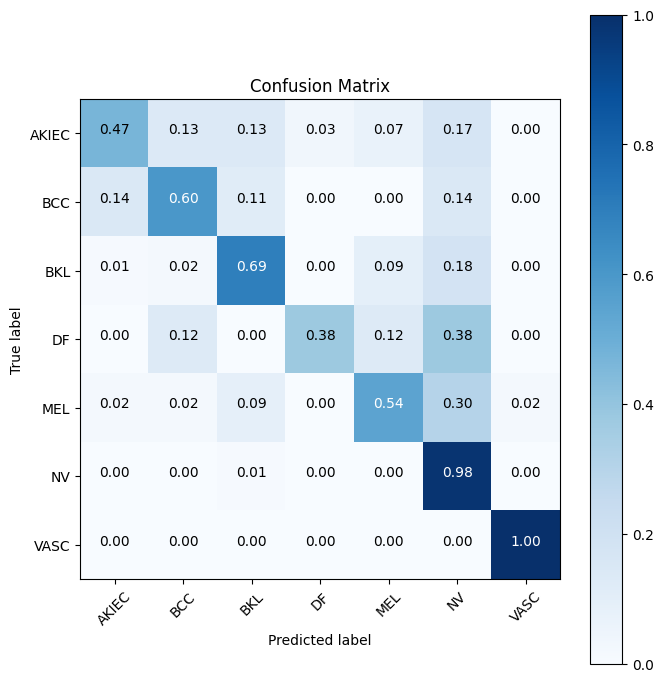

In [46]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusionmatrix_valloss.png', dpi=300)

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [47]:
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.978241,0.978241,0.957389,0.993654,0.968268,0.947416,0.999093,0.974615
f1,0.538462,0.636364,0.721893,0.461538,0.588235,0.967670,0.962963,0.911151
false_discovery_rate,0.363636,0.322581,0.246914,0.400000,0.358974,0.047201,0.071429,0.088849
false_negative_rate,0.533333,0.400000,0.306818,0.625000,0.456522,0.016988,0.000000,0.088849
false_positive_rate,0.007456,0.009363,0.019704,0.001826,0.013245,0.195455,0.000917,0.014808
negative_predictive_value,0.985199,0.986940,0.973581,0.995446,0.980263,0.921875,1.000000,0.985192
positive_predictive_value,0.636364,0.677419,0.753086,0.600000,0.641026,0.952799,0.928571,0.911151
precision,0.636364,0.677419,0.753086,0.600000,0.641026,0.952799,0.928571,0.911151
recall,0.466667,0.600000,0.693182,0.375000,0.543478,0.983012,1.000000,0.911151
sensitivity,0.466667,0.600000,0.693182,0.375000,0.543478,0.983012,1.000000,0.911151
